In [3]:
# install dependency of the preprocessing for BERT inputs
!pip install -q tensorflow-text

In [4]:
!pip install -q tf-models-official

In [5]:
import os
import shutil
import re

import tensorflow as tf
import pandas as pd
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

Download and extract the dataset.


In [9]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

train_dir = os.path.join(dataset_dir, 'train')

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

84131840/84125825 [==============================] - 3s 0us/step


In [10]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [11]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [12]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [13]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)
print(text_preprocessed)

{'input_word_ids': <tf.Tensor: shape=(1, 128), dtype=int32, numpy=
array([[ 101, 2023, 2003, 2107, 2019, 6429, 3185,  999,  102,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0]], dtype=int32)>, 'input_mask': <tf.Tensor: shape=(1, 128), dtype=int3

## Setup BERT model

In [14]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [15]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Pooled Outputs Shape:(1, 768)
Pooled Outputs Values:[-0.92169905 -0.39353544 -0.53932065  0.6825632   0.43848684 -0.14021216
  0.8774716   0.26043403 -0.63113207 -0.9999657  -0.2632019   0.8510541 ]
Sequence Outputs Shape:(1, 128, 768)
Sequence Outputs Values:[[ 0.19451521  0.25141707  0.19074991 ... -0.24845055  0.3856859
   0.13291013]
 [-0.59478724 -0.3942039   0.25245732 ... -0.7694684   1.1564159
   0.32475767]
 [ 0.00641547 -0.15766479  0.5461029  ... -0.17451122  0.6028951
   0.42672256]
 ...
 [ 0.21948367 -0.20927016  0.5386838  ...  0.24693456  0.18250936
  -0.44426975]
 [ 0.01080247 -0.44553152  0.35991025 ...  0.31722748  0.23562762
  -0.6307049 ]
 [ 0.29321158 -0.10581823  0.6114763  ...  0.20745681  0.14494625
  -0.3535329 ]]


## Define model



In [16]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

Let's check that the model runs with the output of the preprocessing model.

In [17]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.5872885]], shape=(1, 1), dtype=float32)


### Loss function


In [18]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

### Optimizer
use the same optimizer that BERT was originally trained with: the "Adaptive Moments" (Adam). 

In [19]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 1e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

### Loading the BERT model and training

In [20]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [21]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/5
625/625 [==============================] - 638s 998ms/step - loss: 0.5670 - binary_accuracy: 0.6588 - val_loss: 0.3056 - val_binary_accuracy: 0.8652
Epoch 2/5
625/625 [==============================] - 621s 993ms/step - loss: 0.2918 - binary_accuracy: 0.8708 - val_loss: 0.3024 - val_binary_accuracy: 0.8794
Epoch 3/5
625/625 [==============================] - 621s 993ms/step - loss: 0.2164 - binary_accuracy: 0.9157 - val_loss: 0.3579 - val_binary_accuracy: 0.8800
Epoch 4/5
625/625 [==============================] - 621s 993ms/step - loss: 0.1683 - binary_accuracy: 0.9370 - val_loss: 0.3750 - val_binary_accuracy: 0.8826
Epoch 5/5
625/625 [==============================] - 620s 993ms/step - loss: 0.1373 - binary_accuracy: 0.9522 - val_loss: 0.4136 - val_binary_accuracy: 0.8814


### Evaluate the model

In [22]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

782/782 [==============================] - 258s 329ms/step - loss: 0.3977 - binary_accuracy: 0.8826
Loss: 0.39771199226379395
Accuracy: 0.8826000094413757


### Plot the accuracy and loss over time

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


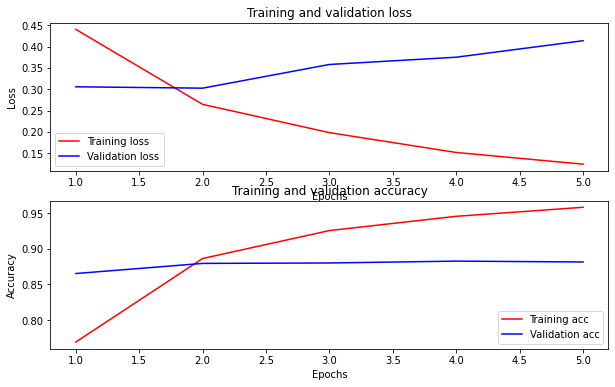

In [25]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
plt.plot(epochs, loss, 'r', label='Training loss')

plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In this plot, the red lines represents the training loss and accuracy, and the blue lines are the validation loss and accuracy.

In [6]:
model_fname = 'IMDB_BERT_CLASSIFIER'
my_wd = '/content/drive/MyDrive/Colab Notebooks/Models/'
saved_model_path = os.path.join(my_wd, model_fname)

In [24]:
classifier_model.save(saved_model_path, include_optimizer=False)

In [7]:
model = tf.saved_model.load(saved_model_path)

In [15]:
data_file_name_dict = {
    '2014':'bostonglobe2014.csv',
    '2015':'bostonglobe2016.csv',
    '2016':'bostonglobe2015.csv',
    '2017':'bostonglobe2017.csv',
    # '2018':'bostonglobe2018.csv',
}

In [16]:
def process_sentences(raw_sentences, target_words):
  selected_sentences = []
  for raw_sentence in raw_sentences:
    result = [word for word in target_words if(word in raw_sentence)]
    if (bool(result)):
      raw_sentence = re.sub(r"[\[\]]", "", raw_sentence)
      selected_sentences.append(raw_sentence)
  print(len(selected_sentences))
  return selected_sentences

In [17]:
def process_predict_sentiments(file_names):
  target_words = ['black', 'haitian', 'jamaican', 'dominican']
  total_sentiment_frequency = {}

  for key, val in file_names.items():
    df = pd.read_csv(f'/content/drive/MyDrive/Boston Globe/{val}',
                 encoding='ISO-8859-1')
    df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
    raw_sentences = df.values[:, 0]
    pred_sentences = process_sentences(raw_sentences, target_words)
    parsed_results = tf.sigmoid(model(tf.constant(pred_sentences))).numpy()
    sentiment_frequency = { 
      "Negative": 0,
      "Positive": 0,
    }
    for i in parsed_results:
      if (i[0] > 0.5):
        sentiment_frequency['Positive'] += 1
      else:
        sentiment_frequency['Negative'] += 1
    total_sentiment_frequency[key] = sentiment_frequency
  return total_sentiment_frequency

In [18]:
total_sentiment_frequency = process_predict_sentiments(data_file_name_dict)

558
1286
779
1544


In [19]:
total_sentiment_frequency

{'2014': {'Negative': 116, 'Positive': 442},
 '2015': {'Negative': 318, 'Positive': 968},
 '2016': {'Negative': 180, 'Positive': 599},
 '2017': {'Negative': 440, 'Positive': 1104}}

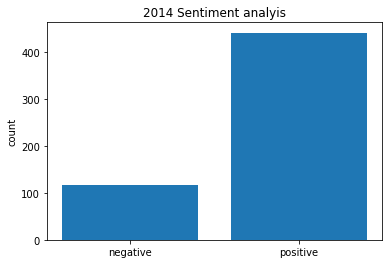

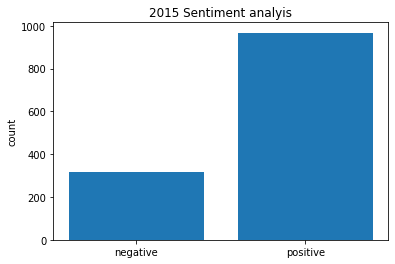

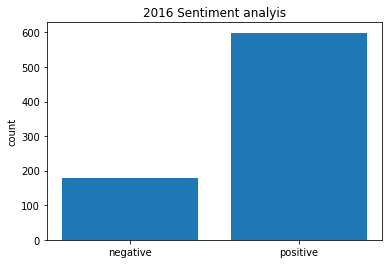

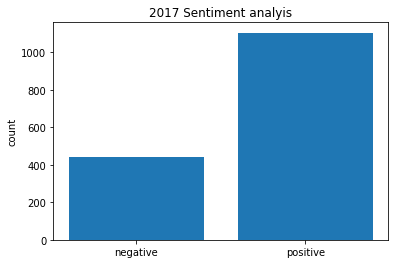

In [24]:
for key, val in total_sentiment_frequency.items():
  # val
  plt.title(f'{key} Sentiment analyis')
  plt.bar(['negative', 'positive'], [val['Negative'], val['Positive']])
  plt.ylabel('count')
  plt.show()